link to dataset: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams

**Phase 1: Data Exploration and Cleaning**

---

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [118]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [119]:
df.shape #1000 rows, 8 features

(1000, 8)

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


I will check which of the object features I can turn into numerical.

In [121]:
print(df['gender'].value_counts())
print(df['race/ethnicity'].value_counts())
print(df['parental level of education'].value_counts())
print(df['lunch'].value_counts())
print(df['test preparation course'].value_counts())

gender
female    518
male      482
Name: count, dtype: int64
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64
parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64
lunch
standard        645
free/reduced    355
Name: count, dtype: int64
test preparation course
none         642
completed    358
Name: count, dtype: int64


I see that I can make the following features binary: gender (female or male), lunch (free/reduced or standard), and test preparation course (none or completed)

In [122]:
df['gender_binary'] = df['gender'].map({'female': 0, 'male': 1})
df['lunch_binary'] = df['lunch'].map({'free/reduced': 0, 'standard': 1})
df['test_preparation_binary'] = df['test preparation course'].map({'none': 0, 'completed': 1})

df[['gender', 'gender_binary', 'lunch', 'lunch_binary',
          'test preparation course', 'test_preparation_binary']].head()

,gender,gender_binary,lunch,lunch_binary,test preparation course,test_preparation_binary
0,female,0,standard,1,none,0
1,female,0,standard,1,completed,1
2,female,0,standard,1,none,0
3,male,1,free/reduced,0,none,0
4,male,1,standard,1,none,0


In [123]:
df.describe()

,math score,reading score,writing score,gender_binary,lunch_binary,test_preparation_binary
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000,0.482000,0.645000,0.358000
std,15.16308,14.600192,15.195657,0.499926,0.478753,0.479652
min,0.00000,17.000000,10.000000,0.000000,0.000000,0.000000
25%,57.00000,59.000000,57.750000,0.000000,0.000000,0.000000
50%,66.00000,70.000000,69.000000,0.000000,1.000000,0.000000
75%,77.00000,79.000000,79.000000,1.000000,1.000000,1.000000
max,100.00000,100.000000,100.000000,1.000000,1.000000,1.000000


From external info on the dataset: 0 indicates no significant heart disease, while 1 to 4 represent more than 50% blockage in any major blood vessel, indicating heart disease, in increasing levels of disease severity.
I will binarize it to have 0 and 1 as a new target column (leaving the original 'num' column for future tests).

Checking percentage of NA values in each column - no NAs

In [124]:
df.isna().sum() / df.shape[0]

,0
gender,0.0
race/ethnicity,0.0
parental level of education,0.0
lunch,0.0
test preparation course,0.0
math score,0.0
reading score,0.0
writing score,0.0
gender_binary,0.0
lunch_binary,0.0


I have 3 target variables in math,reading and writing scores. I will make a unified target variable that has their averege.  

In [125]:
df['average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1).round(2)
df[['math score', 'reading score', 'writing score', 'average_score']].head()

,math score,reading score,writing score,average_score
0,72,72,74,72.67
1,69,90,88,82.33
2,90,95,93,92.67
3,47,57,44,49.33
4,76,78,75,76.33


I will now check the distribution of average score, to decide on a threshold of assigning students into pass or fail in this semester.

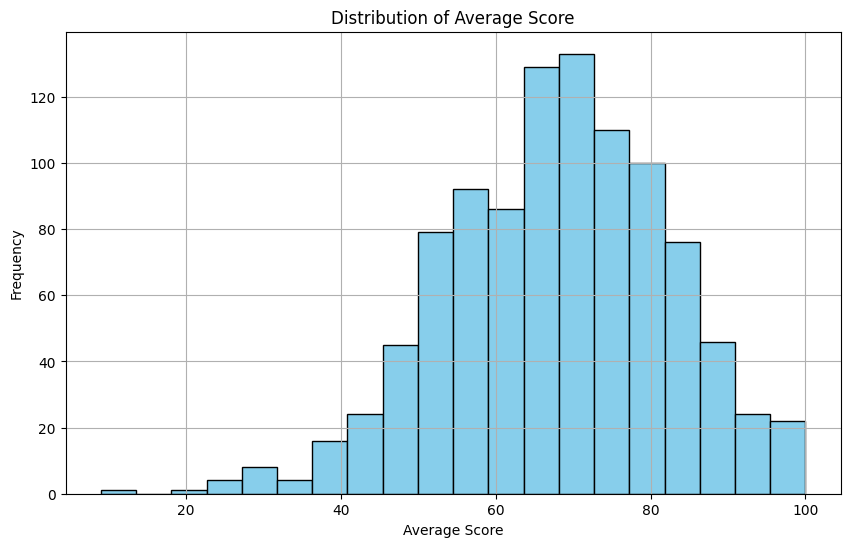

In [126]:
plt.figure(figsize=(10, 6))
df['average_score'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Score')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.show()

The avg score seems skewed with a left tail.

In [127]:
from scipy.stats import skew
# Calculate skewness for 'average_score'
data_skewness = skew(df['average_score'])
print(f"Skewness: {data_skewness}")


Skewness: -0.29859368197068453


In [128]:
percentile_50 = df['average_score'].quantile(0.50)
average = df['average_score'].mean()
print(f"Median:{percentile_50} Averege:{average}")

Median:68.33 Averege:67.77057999999998


I will make the Median (68.33) the threshold for fail/pass (0 or 1) variable which I will call pof (pass or fail).

In [129]:
df['pof'] = df['average_score'].apply(lambda x: 1 if x >= 68.33 else 0)
df[['average_score', 'pof']].head()

,average_score,pof
0,72.67,1
1,82.33,1
2,92.67,1
3,49.33,0
4,76.33,1


Correlation matrix of (so-far) numerical features reveals 4 main connections:
1. All 3 original scores are highly positively correlated (0.8-0.82) between themselves, and therfore also to pof (0.73-0.78).
2. Gender is negatively correlated with all scores (0.17-0.3), but is not related to lunch or test prep (~0).
3. A standard lunch is positively correlated with scores (0.23-0.35), but not related to test prep.
4. test prep is similarly positively correlated with scores (0.18-0.31).


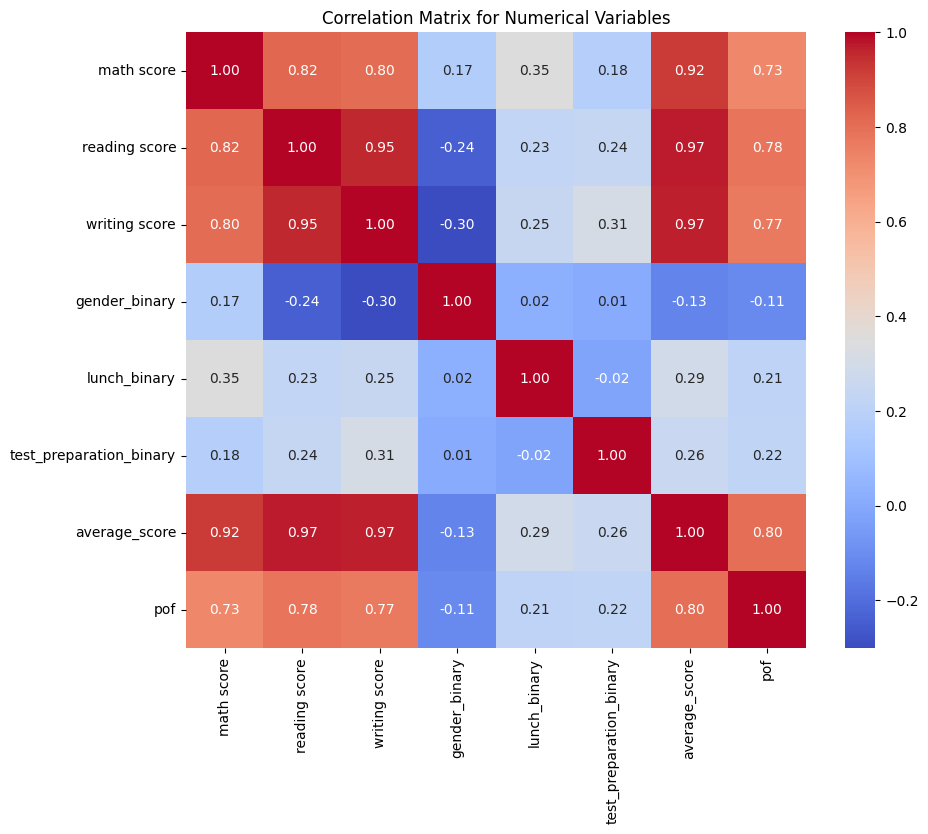

In [130]:
correlation_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))  # Adjust the size to fit your data
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

Apply 1-hot-encoding to race, and make it 0 and 1

In [131]:
dummies = pd.get_dummies(df['race/ethnicity'], prefix='race', drop_first=False)
df = pd.concat([df, dummies], axis=1)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_binary,lunch_binary,test_preparation_binary,average_score,pof,race_group A,race_group B,race_group C,race_group D,race_group E
0,female,group B,bachelor's degree,standard,none,72,72,74,0,1,0,72.67,1,False,True,False,False,False
1,female,group C,some college,standard,completed,69,90,88,0,1,1,82.33,1,False,False,True,False,False
2,female,group B,master's degree,standard,none,90,95,93,0,1,0,92.67,1,False,True,False,False,False
3,male,group A,associate's degree,free/reduced,none,47,57,44,1,0,0,49.33,0,True,False,False,False,False
4,male,group C,some college,standard,none,76,78,75,1,1,0,76.33,1,False,False,True,False,False


In [132]:
df = df.replace({True: 1, False: 0})
df.head()

<ipython-input-132-15a45377c767>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_binary,lunch_binary,test_preparation_binary,average_score,pof,race_group A,race_group B,race_group C,race_group D,race_group E
0,female,group B,bachelor's degree,standard,none,72,72,74,0,1,0,72.67,1,0,1,0,0,0
1,female,group C,some college,standard,completed,69,90,88,0,1,1,82.33,1,0,0,1,0,0
2,female,group B,master's degree,standard,none,90,95,93,0,1,0,92.67,1,0,1,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,1,0,0,49.33,0,1,0,0,0,0
4,male,group C,some college,standard,none,76,78,75,1,1,0,76.33,1,0,0,1,0,0


Apply ordinal mapping labels to parental level of education


In [133]:
education_mapping = {
    "some high school": 1,
    "high school": 1,
    "associate's degree": 2,
    "some college": 3,
    "bachelor's degree": 3,
    "master's degree": 4
}
df['edulvl'] = df['parental level of education'].replace(education_mapping).astype(int)
df.head()

<ipython-input-133-8c1d33c3fbd6>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['edulvl'] = df['parental level of education'].replace(education_mapping).astype(int)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_binary,lunch_binary,test_preparation_binary,average_score,pof,race_group A,race_group B,race_group C,race_group D,race_group E,edulvl
0,female,group B,bachelor's degree,standard,none,72,72,74,0,1,0,72.67,1,0,1,0,0,0,3
1,female,group C,some college,standard,completed,69,90,88,0,1,1,82.33,1,0,0,1,0,0,3
2,female,group B,master's degree,standard,none,90,95,93,0,1,0,92.67,1,0,1,0,0,0,4
3,male,group A,associate's degree,free/reduced,none,47,57,44,1,0,0,49.33,0,1,0,0,0,0,2
4,male,group C,some college,standard,none,76,78,75,1,1,0,76.33,1,0,0,1,0,0,3


Scaling the features to a standard normal distrubution.

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(
    df.select_dtypes(include=['float64', 'int64']))
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_binary,lunch_binary,test_preparation_binary,average_score,pof,race_group A,race_group B,race_group C,race_group D,race_group E,edulvl
0,female,group B,bachelor's degree,standard,none,0.390024,0.193999,0.391492,-0.964625,0.741881,-0.746748,0.343815,0.978237,-0.312562,2.064742,-0.684419,-0.59583,-0.403473,0.937987
1,female,group C,some college,standard,completed,0.192076,1.427476,1.313269,-0.964625,0.741881,1.339140,1.021701,0.978237,-0.312562,-0.484322,1.461094,-0.59583,-0.403473,0.937987
2,female,group B,master's degree,standard,none,1.577711,1.770109,1.642475,-0.964625,0.741881,-0.746748,1.747306,0.978237,-0.312562,2.064742,-0.684419,-0.59583,-0.403473,1.965356
3,male,group A,associate's degree,free/reduced,none,-1.259543,-0.833899,-1.583744,1.036672,-1.347925,-0.746748,-1.294059,-1.022247,3.199368,-0.484322,-0.684419,-0.59583,-0.403473,-0.089381
4,male,group C,some college,standard,none,0.653954,0.605158,0.457333,1.036672,0.741881,-0.746748,0.600653,0.978237,-0.312562,-0.484322,1.461094,-0.59583,-0.403473,0.937987


Box plotting

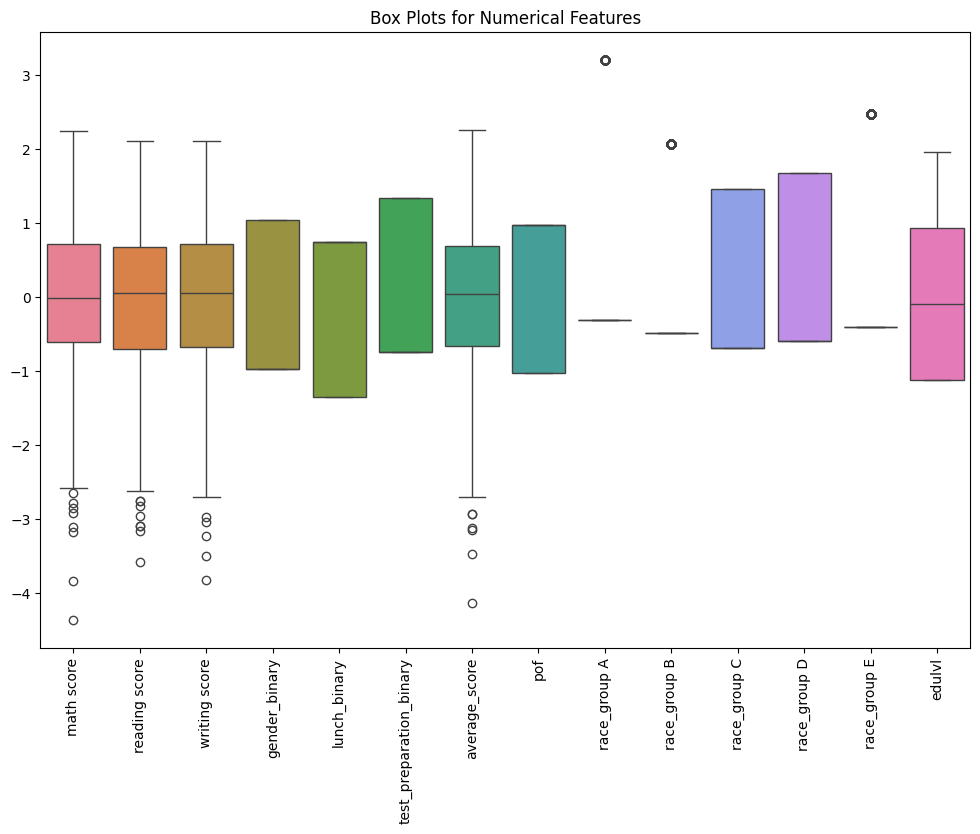

In [135]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title("Box Plots for Numerical Features")
plt.xticks(rotation=90)
plt.show()

The race outliers are not meaningful because they stem from the one-hot encoding. I know that all scores fall between 0-100 and therfore keep outliers.



Histograms:

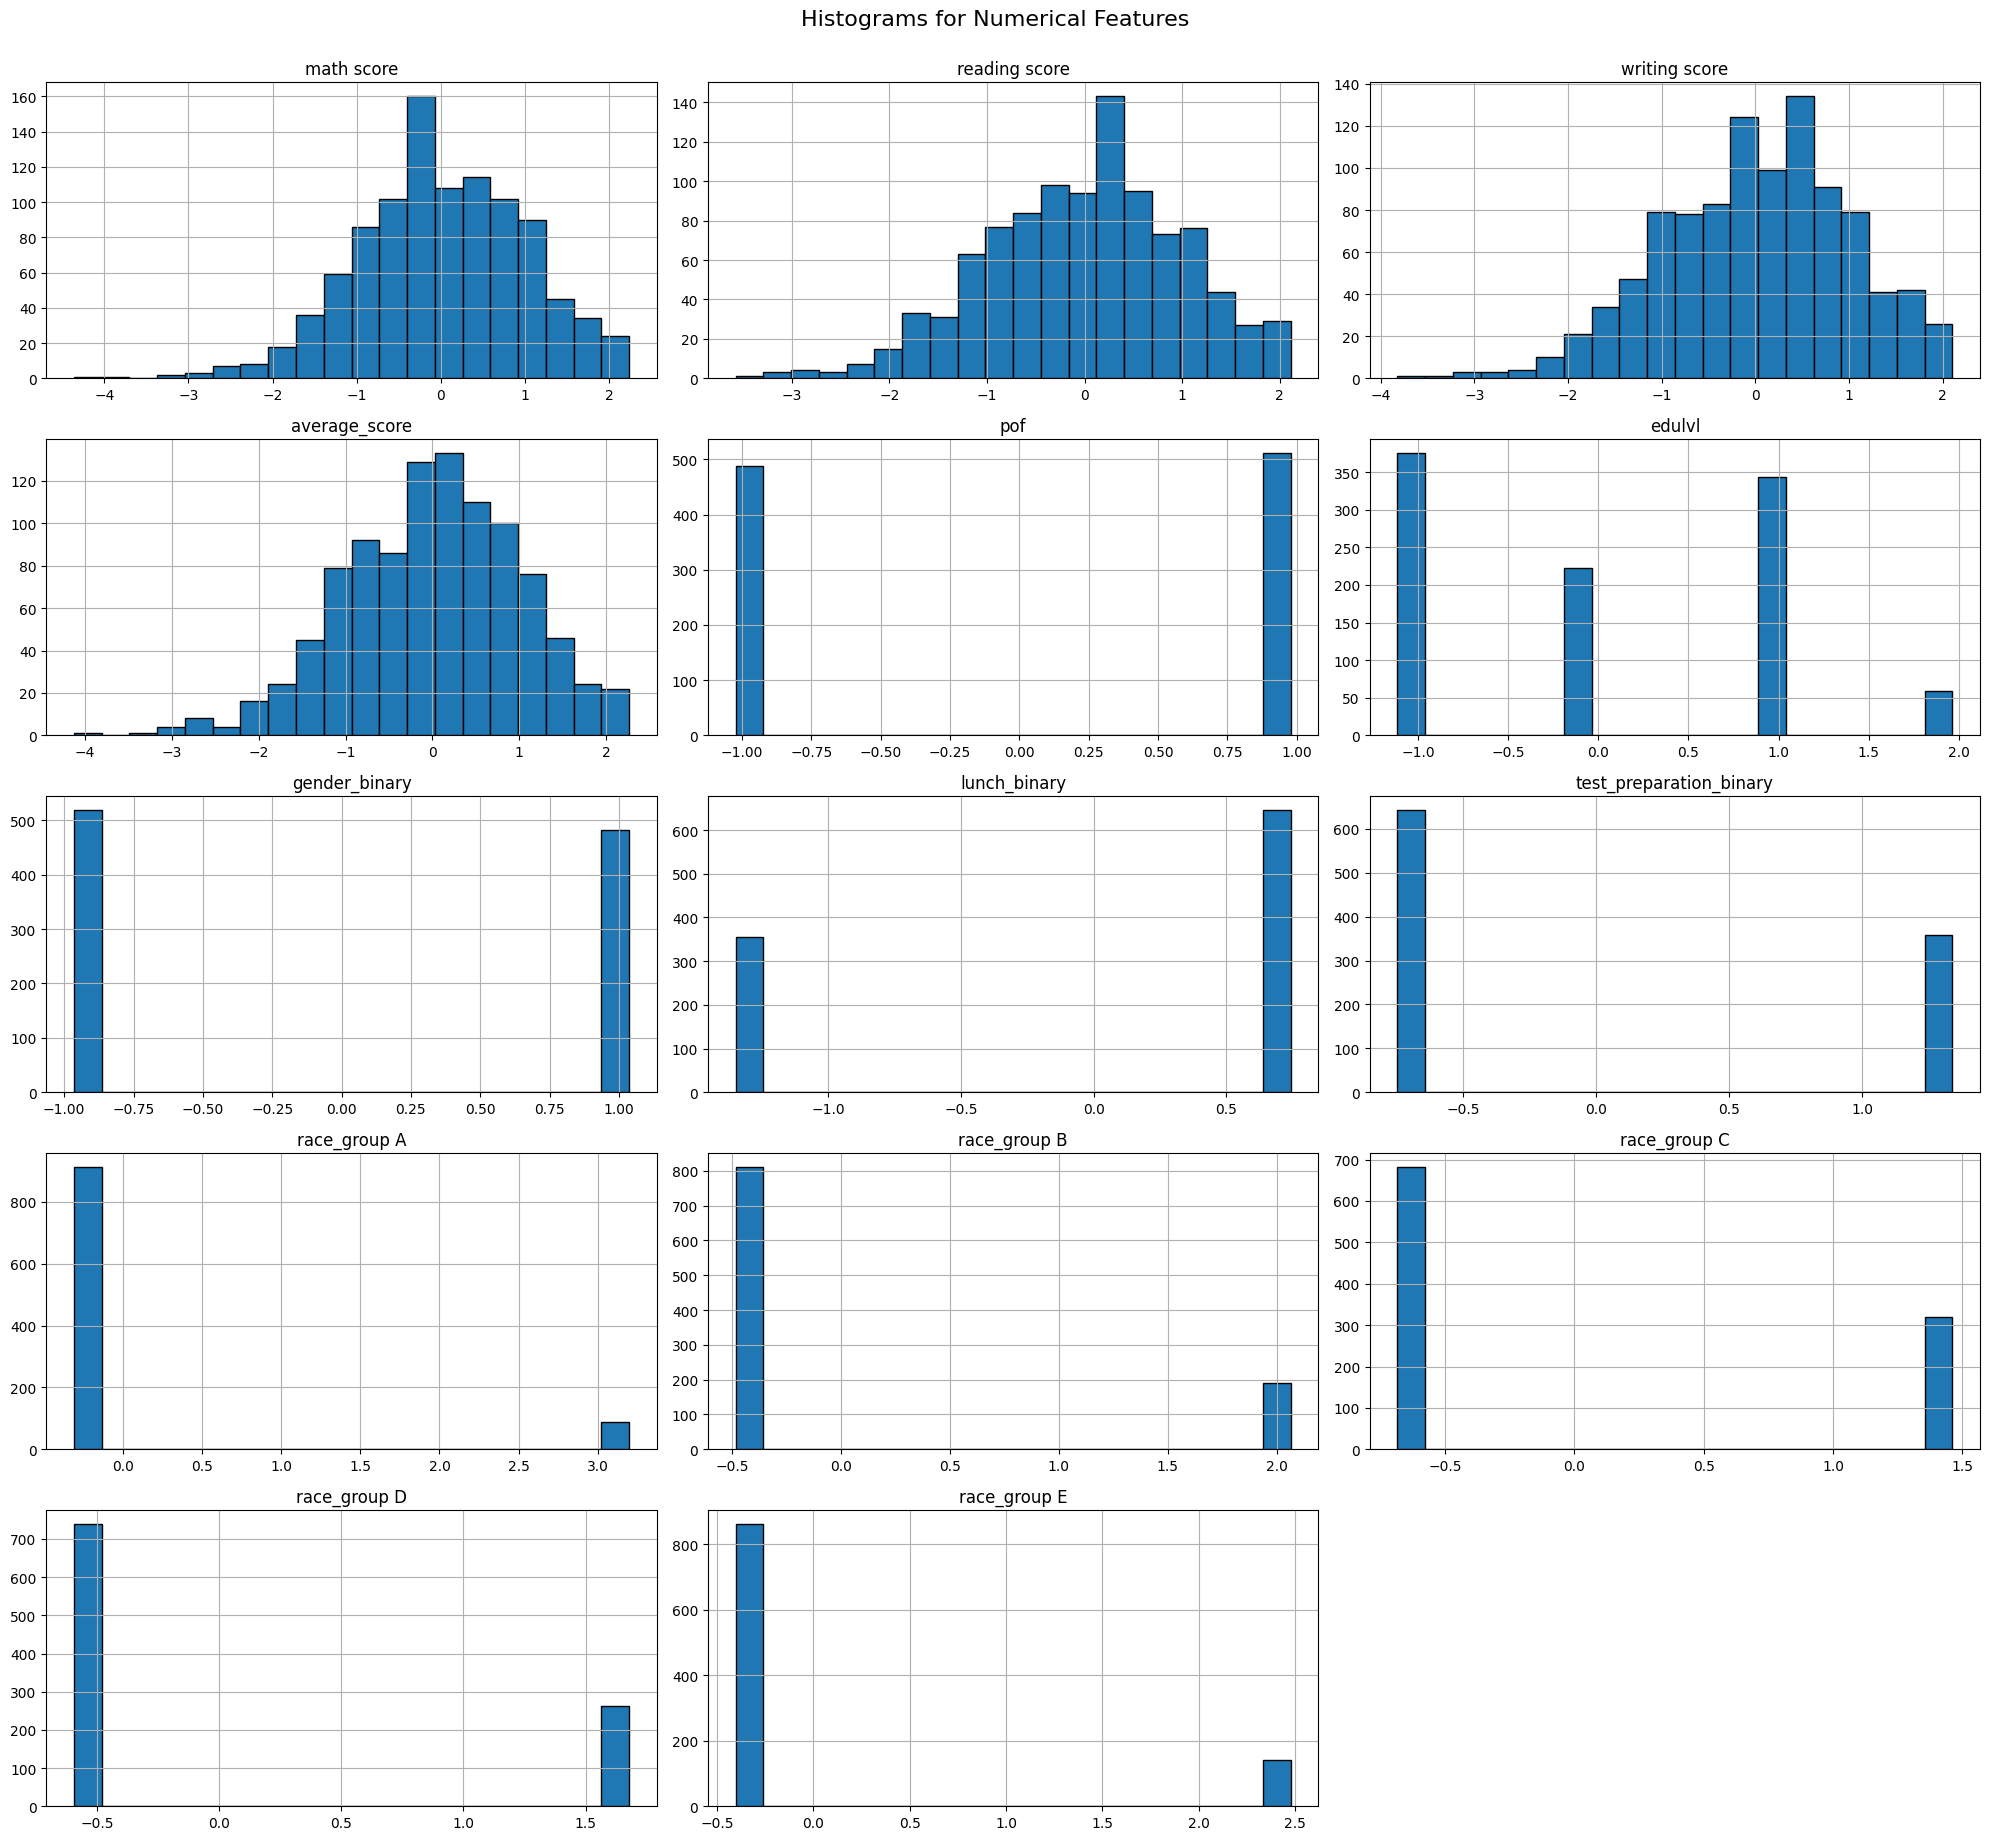

In [136]:
numerical_features = ['math score', 'reading score', 'writing score', 'average_score', 'pof', 'edulvl',
                      'gender_binary', 'lunch_binary', 'test_preparation_binary', 'race_group A',
                      'race_group B', 'race_group C', 'race_group D', 'race_group E']
plt.figure(figsize=(20, 18))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 3, i)  # 5 rows, 3 columns (adjust according to the number of features)
    df[feature].hist(bins=20, edgecolor='black')
    plt.title(feature)
plt.tight_layout()
plt.suptitle("Histograms for Numerical Features", fontsize=16, y=1.02)
plt.show()

Histograms show that only a small minority of parents have a master's degree (~50/1000). Therfore, when splitting to train and test we will double the amount of master's degree instances in the training set by including them twice. Race group A is also relatively a minority but has enough samples (89).

Skewness:

In [137]:
skewness = df[numerical_features].skew()
print("Skewness of numerical features:\n", skewness)

Skewness of numerical features:
 math score                -0.278935
reading score             -0.259105
writing score             -0.289444
average_score             -0.299042
pof                       -0.044077
edulvl                     0.209666
gender_binary              0.072155
lunch_binary              -0.606955
test_preparation_binary    0.593282
race_group A               2.891145
race_group B               1.582795
race_group C               0.777843
race_group D               1.084127
race_group E               2.078124
dtype: float64


**Scores:** slight left-skew. The majority of scores are higher, with fewer low values pulling the distribution left. This is typical in many educational datasets where more students perform better, with only a small group scoring lower.

**pof, edulvl and gender** are almost symmetric.

**lunch and test prep** have 2/3 at standard and no prep, therfore skewed to the left and right respectively.





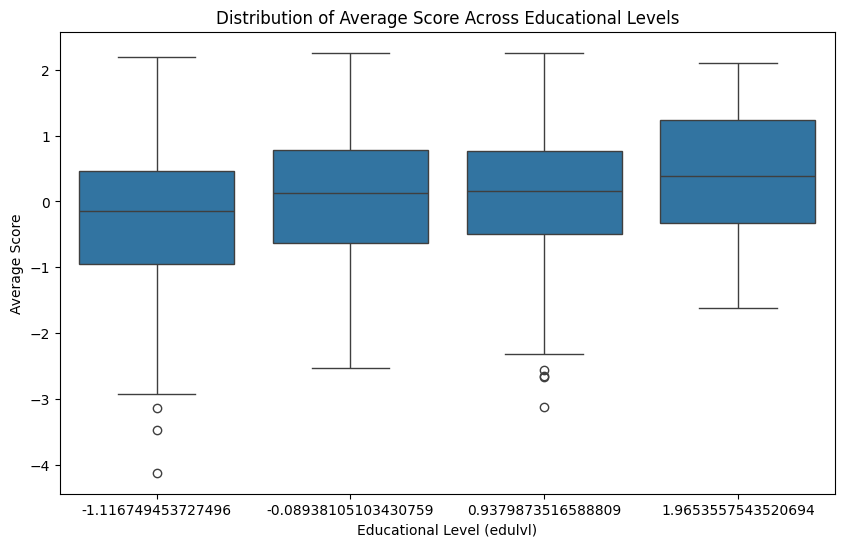

In [138]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='edulvl', y='average_score', data=df)
plt.title('Distribution of Average Score Across Educational Levels')
plt.xlabel('Educational Level (edulvl)')
plt.ylabel('Average Score')
plt.show()

A boxplot of the avg score distribution in different parents education level shows no difference for BA or Associate degree, but better distribution for MA and worse for Highschool one.

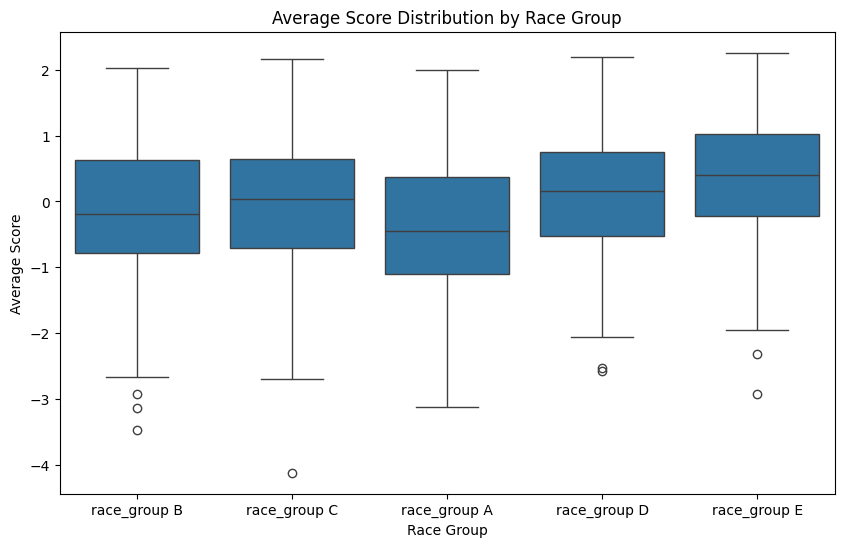

In [139]:
# Create a box plot to visualize the distribution of average scores by race group
df['race_group'] = df[['race_group A', 'race_group B', 'race_group C', 'race_group D', 'race_group E']].idxmax(axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x='race_group', y='average_score', data=df)
plt.title('Average Score Distribution by Race Group')
plt.xlabel('Race Group')
plt.ylabel('Average Score')
plt.show()

Looking at boxplots of avg score dist for each race, we can see race group A performs the worst, race E performs best, and the rest are similar in between

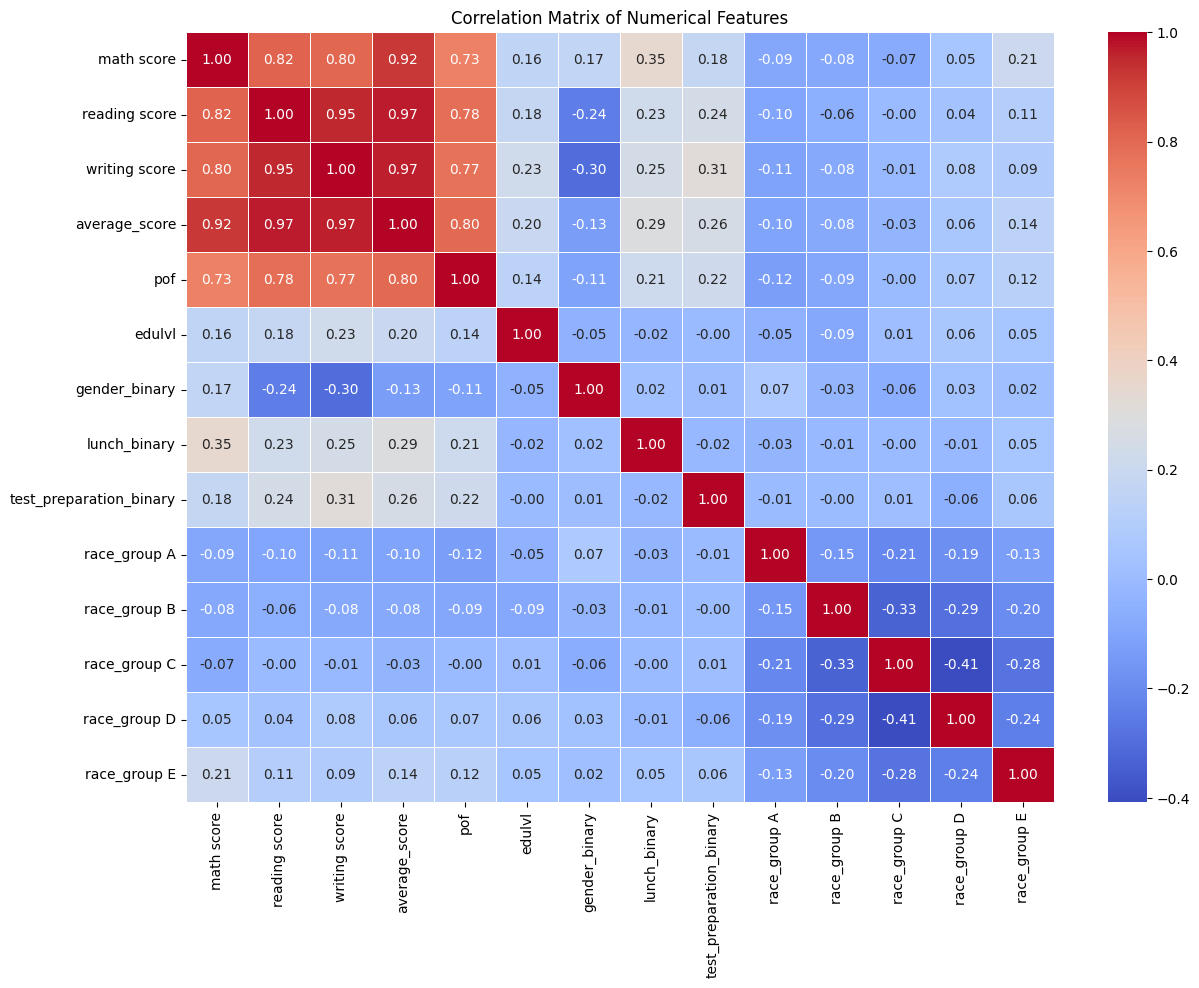

In [140]:
corr_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

We see no correlation between race group and edulvl, test prep and lunch - meaning there are no major ineualities perofrming in the background.

**Phase 2: Hypothesis Formulation**

---


**During EDA we saw some general correlation between test prep and lunches to general success in grades**. However, it is unclear whether these resources are important by themselves or correlated with other features (such as race or parental education for example).

**In the following section, we will try to check which features are mostly influential for predicting the quantile of the math grade. The significance of math in school is known to be very significant for future salaries and career success, as it is an important pre-condition for suceeding in STEM subjects in higher education. Therfore, we should zoom into it to research the specific conditions for success.**

**The answer to this question could guide the resource allocation**. For example, if we see that for lunch and prep are not as important as demographic background (like gender, parental education or race), we may need new instruments to help students from less priviledged groups to succeed. On the other hand, if we see that these instruments are in fact ifluential, we could grant more financial aid to help students enjoy them.

**Phase 3: Supervised Learning**

---



Since our main focus is on feature importance, our baseline model will be a multi-class logistic regression (allowing direct interpretability from its coefficients), and later on we will employ random forest and XGBoost. My prediction is that XGB will perform best.

**Logistic Regression**

Creating the target variable - math quantile (mq)

In [141]:
df['mq'] = pd.qcut(df['math score'], q=4, labels=[0, 1, 2, 3])
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,gender_binary,lunch_binary,...,average_score,pof,race_group A,race_group B,race_group C,race_group D,race_group E,edulvl,race_group,mq
0,female,group B,bachelor's degree,standard,none,0.390024,0.193999,0.391492,-0.964625,0.741881,...,0.343815,0.978237,-0.312562,2.064742,-0.684419,-0.595830,-0.403473,0.937987,race_group B,2
1,female,group C,some college,standard,completed,0.192076,1.427476,1.313269,-0.964625,0.741881,...,1.021701,0.978237,-0.312562,-0.484322,1.461094,-0.595830,-0.403473,0.937987,race_group C,2
2,female,group B,master's degree,standard,none,1.577711,1.770109,1.642475,-0.964625,0.741881,...,1.747306,0.978237,-0.312562,2.064742,-0.684419,-0.595830,-0.403473,1.965356,race_group B,3
3,male,group A,associate's degree,free/reduced,none,-1.259543,-0.833899,-1.583744,1.036672,-1.347925,...,-1.294059,-1.022247,3.199368,-0.484322,-0.684419,-0.595830,-0.403473,-0.089381,race_group A,0
4,male,group C,some college,standard,none,0.653954,0.605158,0.457333,1.036672,0.741881,...,0.600653,0.978237,-0.312562,-0.484322,1.461094,-0.595830,-0.403473,0.937987,race_group C,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,1.445746,2.044215,1.774157,-0.964625,0.741881,...,1.840638,0.978237,-0.312562,-0.484322,-0.684419,-0.595830,2.478479,1.965356,race_group E,3
996,male,group C,high school,free/reduced,none,-0.269803,-0.970952,-0.859491,1.036672,-1.347925,...,-0.732663,-1.022247,-0.312562,-0.484322,1.461094,-0.595830,-0.403473,-1.116749,race_group C,1
997,female,group C,high school,free/reduced,completed,-0.467751,0.125472,-0.201079,-0.964625,-1.347925,...,-0.194424,-1.022247,-0.312562,-0.484322,1.461094,-0.595830,-0.403473,-1.116749,race_group C,1
998,female,group D,some college,standard,completed,0.126093,0.605158,0.589015,-0.964625,0.741881,...,0.460304,0.978237,-0.312562,-0.484322,-0.684419,1.678331,-0.403473,0.937987,race_group D,2


When splitting to train and test I wish to provide more examples with a parental education of masters degree. Therfore I will double the examples for the underrepresented class.
*[I planned to use SMOTE but decided to forefit it due to a need for much backstage work for a very simple and negligable amount of instances]*

In [142]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
X = df[numerical_features]
y = df['mq']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
masters_level_value = 1.965356
range_tolerance = 0.01  # Adjust this value as necessary
masters_indices = X_train[(X_train['edulvl'] >= masters_level_value - range_tolerance) &
                          (X_train['edulvl'] <= masters_level_value + range_tolerance)].index
X_masters = X_train.loc[masters_indices]
y_masters = y_train.loc[masters_indices]
X_masters_doubled = pd.concat([X_masters] * 2, axis=0)  # Duplicate the rows
y_masters_doubled = pd.concat([y_masters] * 2, axis=0)  # Duplicate the target labels
X_train_rest = X_train.drop(masters_indices)
y_train_rest = y_train.drop(masters_indices)
X_train_combined = pd.concat([X_train_rest, X_masters_doubled], axis=0)
y_train_combined = pd.concat([y_train_rest, y_masters_doubled], axis=0)
print("New distribution of 'edulvl' in resampled data:\n", pd.Series(X_train_combined['edulvl']).value_counts())

New distribution of 'edulvl' in resampled data:
 edulvl
-1.116749    292
 0.937987    282
-0.089381    180
 1.965356     92
Name: count, dtype: int64


Remove from the data the actual score features (math, reading, writing, avg and pof)

In [143]:
score_features = ['math score', 'reading score', 'writing score', 'average_score', 'pof']
X_train_filtered = X_train_combined.drop(score_features, axis=1)
X_test_filtered = X_test.drop(score_features, axis=1)
print("Remaining features:")
print(X_train_filtered.columns.tolist())

Remaining features:
['gender_binary', 'lunch_binary', 'test_preparation_binary', 'race_group A', 'race_group B', 'race_group C', 'race_group D', 'race_group E', 'edulvl']


Now we can employ the logistic regression

In [144]:
# Train the multiclass logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
lr_model = LogisticRegression(
    multi_class='multinomial',  # Use multinomial for multiclass
    solver='lbfgs',            # Efficient solver for multiclass problems
    max_iter=1000,             # Increase iterations if needed
    random_state=42
)

# Fit the model
lr_model.fit(X_train_filtered, y_train_combined)

# Make predictions
y_pred_train = lr_model.predict(X_train_filtered)
y_pred_test = lr_model.predict(X_test_filtered)

And analyze

In [145]:

# Calculate probabilities
y_prob_test = lr_model.predict_proba(X_test_filtered)

# Get feature importance (coefficients for each class)
feature_importance = pd.DataFrame(
    lr_model.coef_.T,
    columns=[f'Class_{i}' for i in range(len(np.unique(y_train_combined)))],
    index=X_train_filtered.columns
)
feature_importance

,Class_0,Class_1,Class_2,Class_3
gender_binary,-0.306601,-0.090234,0.018459,0.378376
lunch_binary,-0.508171,-0.085380,0.118912,0.474638
test_preparation_binary,-0.288768,-0.072589,0.096783,0.264574
race_group A,0.168437,0.028987,-0.111828,-0.085596
race_group B,0.013101,0.076763,-0.017840,-0.072023
race_group C,0.054661,0.055537,-0.023630,-0.086568
race_group D,-0.036436,-0.045213,0.069319,0.012330
race_group E,-0.180282,-0.127877,0.055833,0.252327
edulvl,-0.176496,-0.088640,-0.100110,0.365245


In [146]:
# Print model performance metrics
print("Training Set Performance:")
print(classification_report(y_train_combined, y_pred_train))
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))

Training Set Performance:
              precision    recall  f1-score   support

           0       0.45      0.63      0.52       228
           1       0.30      0.13      0.18       198
           2       0.31      0.29      0.30       217
           3       0.44      0.54      0.49       203

    accuracy                           0.40       846
   macro avg       0.38      0.39      0.37       846
weighted avg       0.38      0.40      0.38       846


Test Set Performance:
              precision    recall  f1-score   support

           0       0.44      0.68      0.53        53
           1       0.18      0.08      0.11        48
           2       0.40      0.30      0.34        53
           3       0.38      0.46      0.41        46

    accuracy                           0.38       200
   macro avg       0.35      0.38      0.35       200
weighted avg       0.35      0.39      0.35       200



**We see very poor results (general accuracy - 0.4) on both the test and training set - which suggests the data given (demographics, prep and lunch) is far from sufficing to predict a student's score (makes sense)**

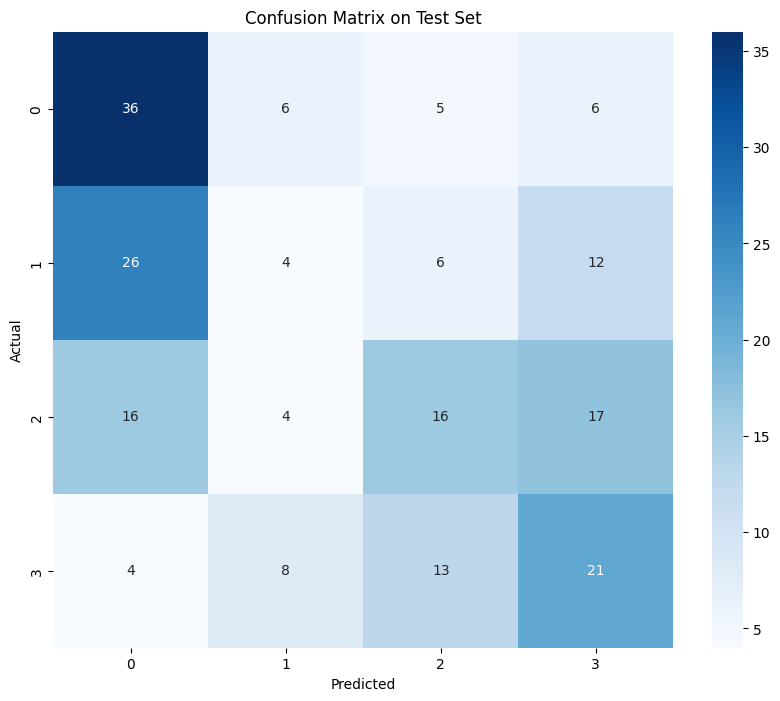

In [147]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**The confusion matrix shows the model identifies the bottom and top quantiles better than the middle ones.**

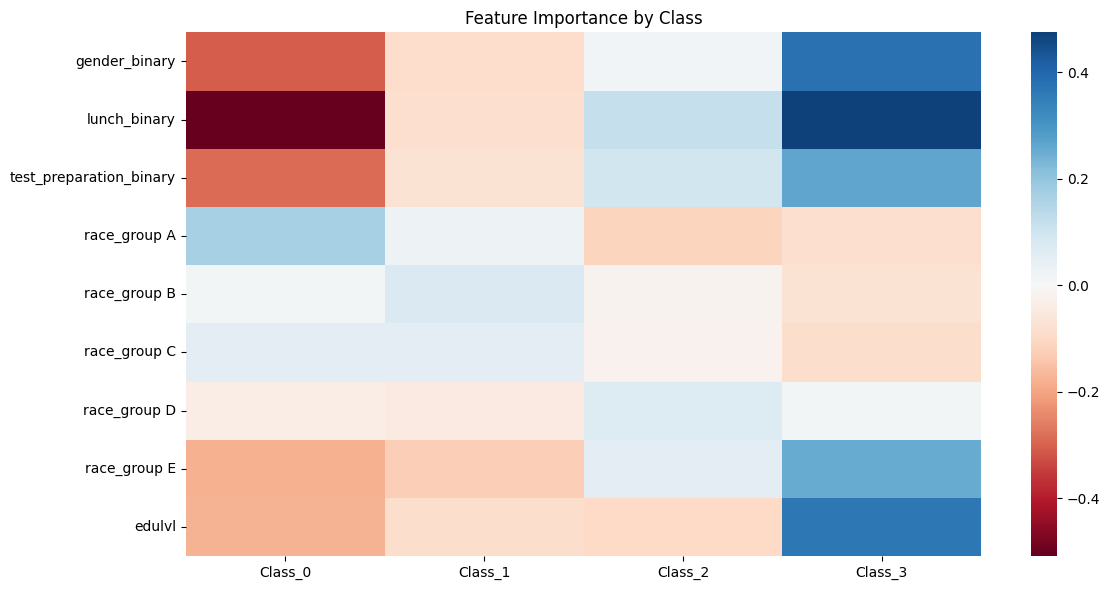

In [148]:
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importance, cmap='RdBu', center=0)
plt.title('Feature Importance by Class')
plt.tight_layout()
plt.show()

**Looking at feature importance by quantile, we can see lunch is the most dominant feature, with gender and test prep right after - but again just for the extreme quantiles (top and bottom 25%).**

Edulvl and Race 'E' are also standing out as an important features (albeit less than the previous ones), and again just for extreme quantiles.

Before making any final conclusions, let us check again the performance of XGBoost

**XGBoost**

I choose to perform CV and tune depth, child weight, and learning rate - with values that suit the small size of instances and number of features.

In [149]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from itertools import product
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.03, 0.05]
}

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=4,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_train_filtered, y_train_combined)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_class=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [2, 3, 4, 5],
                         'min_child_weight': [1, 3, 5]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [150]:
import xgboost as xgb
test_model = xgb.XGBClassifier()

# Check if it inherits from sklearn base classes
print("Base classes:", test_model.__class__.__bases__)
# Check if it has the tags method
print("Has get_tags:", hasattr(test_model, '_get_tags'))
print("Has sklearn_tags:", hasattr(test_model, '__sklearn_tags__'))

Base classes: (<class 'xgboost.sklearn.XGBModel'>, <class 'sklearn.base.ClassifierMixin'>)
Has get_tags: True
Has sklearn_tags: False


In [151]:
# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")



Best parameters found:
{'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5}

Best cross-validation score: 0.3747


We still see a very poor performace

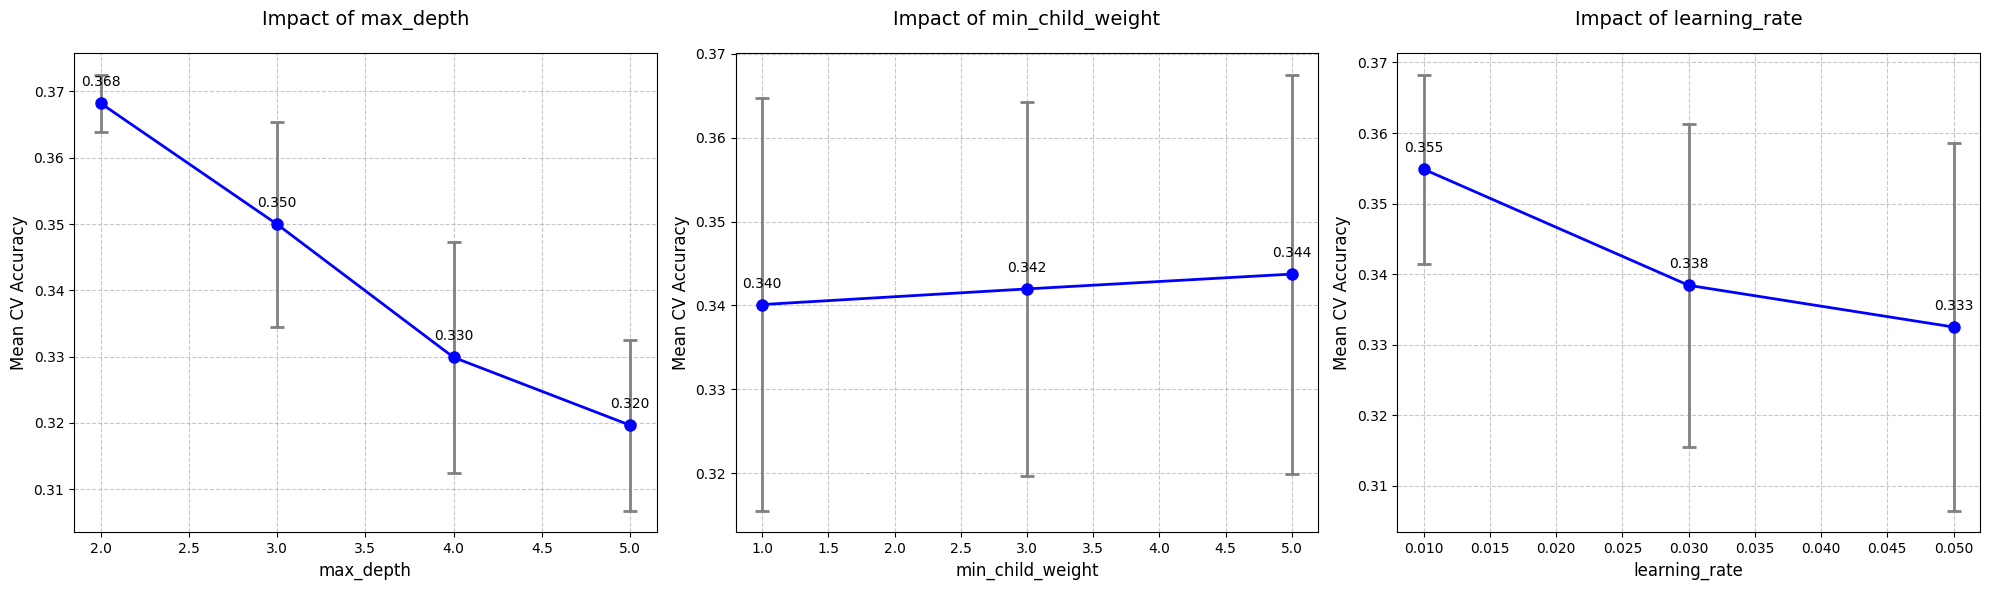

In [152]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')
# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
params = ['max_depth', 'min_child_weight', 'learning_rate']

for i, param in enumerate(params):
    param_name = f'param_{param}'
    grouped_scores = cv_results.groupby(param_name)['mean_test_score'].agg(['mean', 'std'])

    axes[i].errorbar(
        grouped_scores.index.astype(float),
        grouped_scores['mean'],
        yerr=grouped_scores['std'],
        marker='o',
        capsize=5,
        capthick=2,
        markersize=8,
        linewidth=2,
        color='blue',
        ecolor='gray'
    )

    axes[i].set_title(f'Impact of {param}', fontsize=14, pad=20)
    axes[i].set_xlabel(param, fontsize=12)
    axes[i].set_ylabel('Mean CV Accuracy', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)

    for x, (mean, std) in zip(grouped_scores.index.astype(float), grouped_scores.values):
        axes[i].annotate(
            f'{mean:.3f}',
            (x, mean),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            va='bottom'
        )

plt.tight_layout()
plt.show()


In [153]:
# Train final model with best parameters
best_model = xgb.XGBClassifier(
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=4,
    eval_metric=['mlogloss', 'merror'],
    random_state=42,
    **grid_search.best_params_
)

# Fit the final model
best_model.fit(
    X_train_filtered,
    y_train_combined,
    eval_set=[(X_test_filtered, y_test)],
    verbose=True
)

# Make predictions
y_pred_train = pd.Series(best_model.predict(X_train_filtered))
y_pred_test = pd.Series(best_model.predict(X_test_filtered))



[0]	validation_0-mlogloss:1.38306	validation_0-merror:0.62500
[1]	validation_0-mlogloss:1.37872	validation_0-merror:0.64000
[2]	validation_0-mlogloss:1.37345	validation_0-merror:0.60500
[3]	validation_0-mlogloss:1.36895	validation_0-merror:0.59500
[4]	validation_0-mlogloss:1.36521	validation_0-merror:0.60000
[5]	validation_0-mlogloss:1.36082	validation_0-merror:0.61000
[6]	validation_0-mlogloss:1.35752	validation_0-merror:0.60000
[7]	validation_0-mlogloss:1.35583	validation_0-merror:0.59500
[8]	validation_0-mlogloss:1.35283	validation_0-merror:0.58000
[9]	validation_0-mlogloss:1.35172	validation_0-merror:0.58500
[10]	validation_0-mlogloss:1.34805	validation_0-merror:0.59000
[11]	validation_0-mlogloss:1.34459	validation_0-merror:0.60500
[12]	validation_0-mlogloss:1.34140	validation_0-merror:0.57500
[13]	validation_0-mlogloss:1.33849	validation_0-merror:0.57500
[14]	validation_0-mlogloss:1.33651	validation_0-merror:0.60000
[15]	validation_0-mlogloss:1.33475	validation_0-merror:0.60500
[1

In [154]:
# Print final model performance (using adjusted values for both)
print("\nFinal Model Performance:")
print("\nTraining Set Performance:")
print(classification_report(y_train_combined, y_pred_train))
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred_test))


Final Model Performance:

Training Set Performance:
              precision    recall  f1-score   support

           0       0.48      0.54      0.51       228
           1       0.35      0.26      0.30       198
           2       0.35      0.34      0.35       217
           3       0.48      0.57      0.52       203

    accuracy                           0.43       846
   macro avg       0.42      0.43      0.42       846
weighted avg       0.42      0.43      0.42       846


Test Set Performance:
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        53
           1       0.28      0.21      0.24        48
           2       0.41      0.38      0.39        53
           3       0.41      0.41      0.41        46

    accuracy                           0.41       200
   macro avg       0.39      0.41      0.40       200
weighted avg       0.40      0.41      0.40       200



**Performance is still poor, although slightly improved (from 0.38 to 0.41 accuracy)**


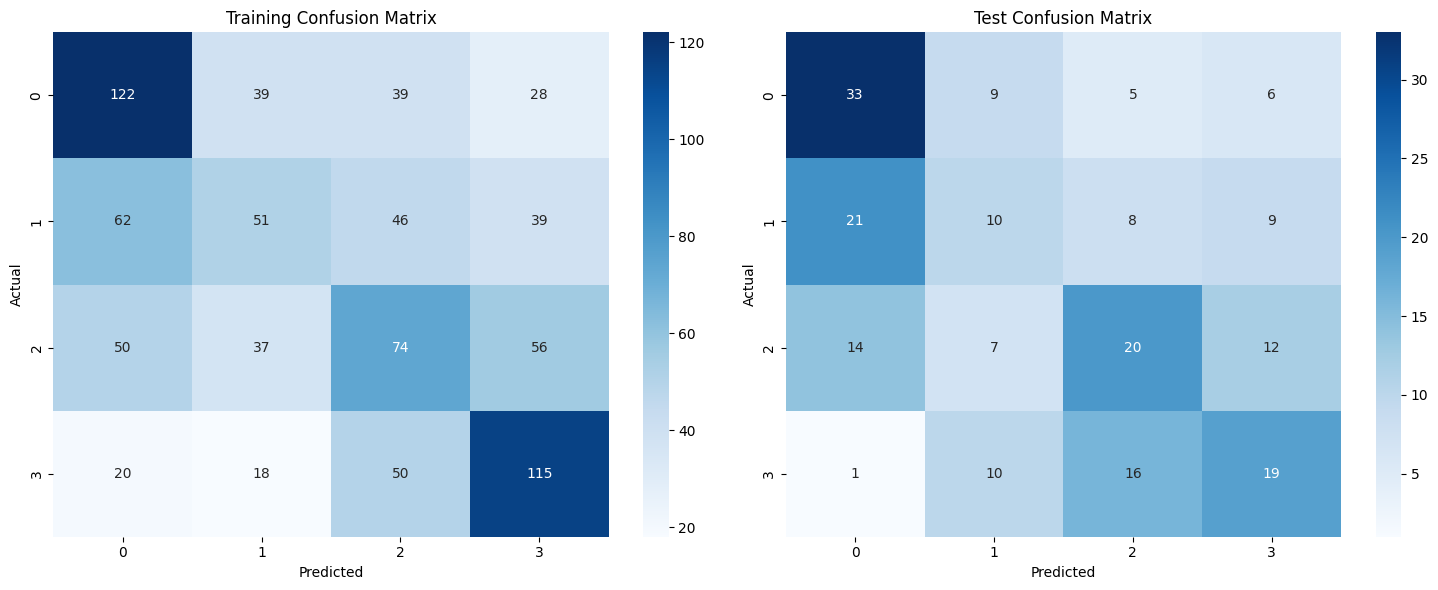

In [155]:
cm_train = confusion_matrix(y_train_combined, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Training Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Test Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

Looking at the confusion matrix we see a similar pattern with extreme quantiles better predicted.

Additionally, mistakes are slightly "smaller" as the confusion is mostly between quantiles 3 and 4, and quantiles 1 and 2.

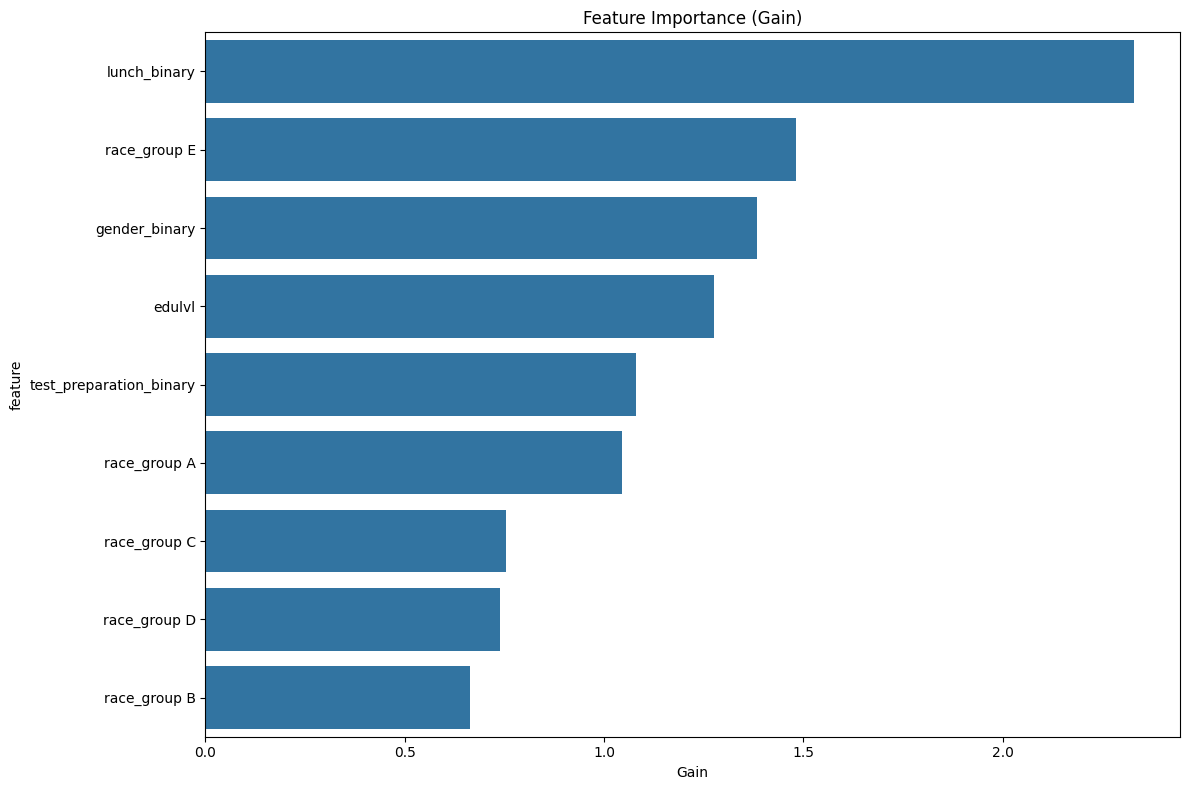

In [156]:
fig, ax = plt.subplots(figsize=(12, 8))

gain_importance = best_model.get_booster().get_score(importance_type='gain')
gain_importance_df = pd.DataFrame.from_dict(gain_importance, orient='index', columns=['importance'])
gain_importance_df = gain_importance_df.reset_index().rename(columns={'index': 'feature'})
gain_importance_df = gain_importance_df.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=gain_importance_df, ax=ax)
ax.set_title('Feature Importance (Gain)')
ax.set_xlabel('Gain')

plt.tight_layout()
plt.show()

Looking at feature importance by gain (the improvement in accuracy brought by a feature to the model) we see that lunch is the most significant one by far, likely since it is correlated with socioeconomic situation. Race 'E' is second (likely from the same reason), gender and parental education are right after it with slightly lower values.

Conclusions on Feature importnace from both models:

1. Lunch is the most important in both of them, likely due to its correlation to socio-economic situation. It may also have intrinsic importance in light of the fact that test prep which can also be correlated with financial situation was not as important. It will likely help to subsidize lunch in any case.
2. Gender is also signifiacnt in both models, and it is not related to financial issues, but to social and cultural tendencies. This may merit special exercise classes for females, and a focus on their excellence.
3. Other features correlated with soci-economic situation like race E and parental education also helped the models, but it is less likely (compared to lunch) that they have an intrinsic inflence.
4. The fact that the models predicted the extreme quantiles shows that current data can only help classify between succesful and unsuccesful math students.
5. The small size of dataset and number of features, as well as the low accuracy scores limit any strong conclusion - it is clear that the math quantile relies heavily on other features.

Future research could try to look into reading and writing and spot differences with math, or check influnces of the general features (test, lunch, edulvl) in each kind of demographic (race and gender).

**Phase 4: Unsupervised Learning**

---



We will now try to discover hidden patterns and relationships with a clustering analysis. First we start with K-Means.

**K-Means Clustering**

Will start with K-Means with 2,3,4 as potential Ks


K = 2 Clustering Results:
Inertia: 6469.911386060465
Silhouette Score: 0.16556480378269173

K = 3 Clustering Results:
Inertia: 5350.540679285247
Silhouette Score: 0.24737078801856976

K = 4 Clustering Results:
Inertia: 4355.880790692778
Silhouette Score: 0.3183204602206993

K = 5 Clustering Results:
Inertia: 3461.9140177531926
Silhouette Score: 0.3779155054245485

K = 6 Clustering Results:
Inertia: 3188.3642030938636
Silhouette Score: 0.3279884089912027

K = 7 Clustering Results:
Inertia: 2954.6409129471904
Silhouette Score: 0.3124458784923871

K = 8 Clustering Results:
Inertia: 2773.347615514679
Silhouette Score: 0.32123755249941505

K = 9 Clustering Results:
Inertia: 2677.539358227292
Silhouette Score: 0.3087520357927028

K = 10 Clustering Results:
Inertia: 2523.810754259558
Silhouette Score: 0.29679509805837817


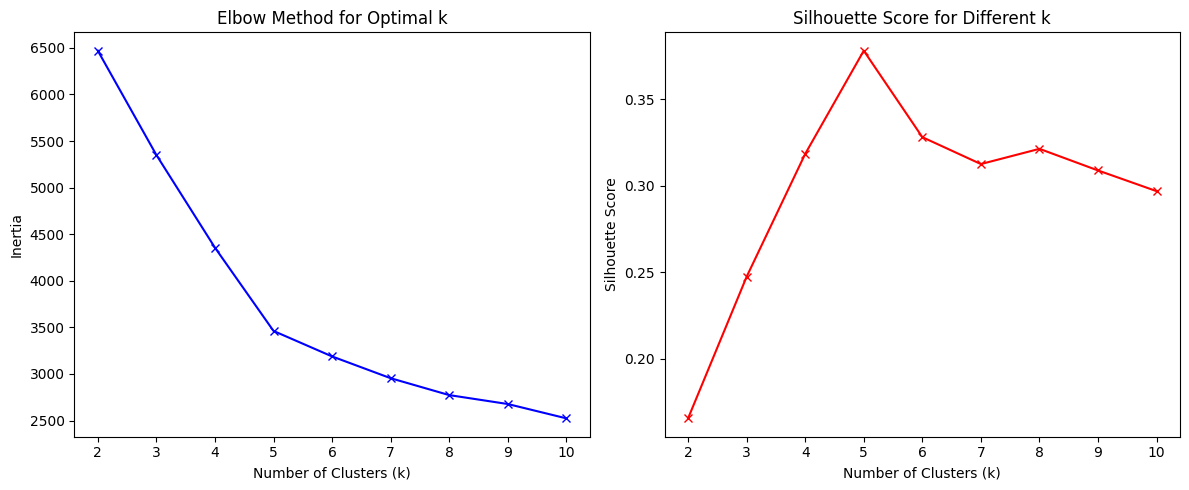

([6469.911386060465,
  5350.540679285247,
  4355.880790692778,
  3461.9140177531926,
  3188.3642030938636,
  2954.6409129471904,
  2773.347615514679,
  2677.539358227292,
  2523.810754259558],
 [0.16556480378269173,
  0.24737078801856976,
  0.3183204602206993,
  0.3779155054245485,
  0.3279884089912027,
  0.3124458784923871,
  0.32123755249941505,
  0.3087520357927028,
  0.29679509805837817])

In [157]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def perform_kmeans_clustering(X_train_filtered, y_train_combined, X_test_filtered, y_test, k_values=[2, 3, 4, 5, 6, 7, 8, 9, 10]):

    inertias = []
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_train_filtered)

        inertias.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(X_train_filtered, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        test_clusters = kmeans.predict(X_test_filtered)

        print(f"\nK = {k} Clustering Results:")
        print(f"Inertia: {kmeans.inertia_}")
        print(f"Silhouette Score: {silhouette_avg}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'rx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different k')

    plt.tight_layout()
    plt.show()

    return inertias, silhouette_scores

perform_kmeans_clustering(X_train_filtered, y_train_combined, X_test_filtered, y_test)

We see that the best results are reached with 5 clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


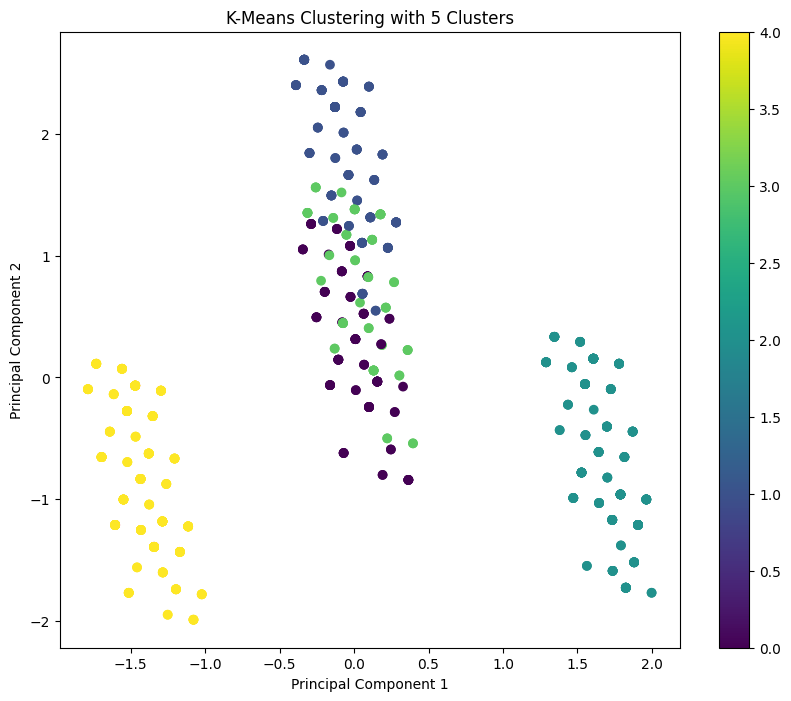

In [158]:
from sklearn.decomposition import PCA
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_filtered)
labels = kmeans.labels_

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_filtered)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering with 5 Clusters')
plt.colorbar()
plt.show()

Visually with 2D it looks like there are 3 seperate clusters. Let's try looking at 3 components.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


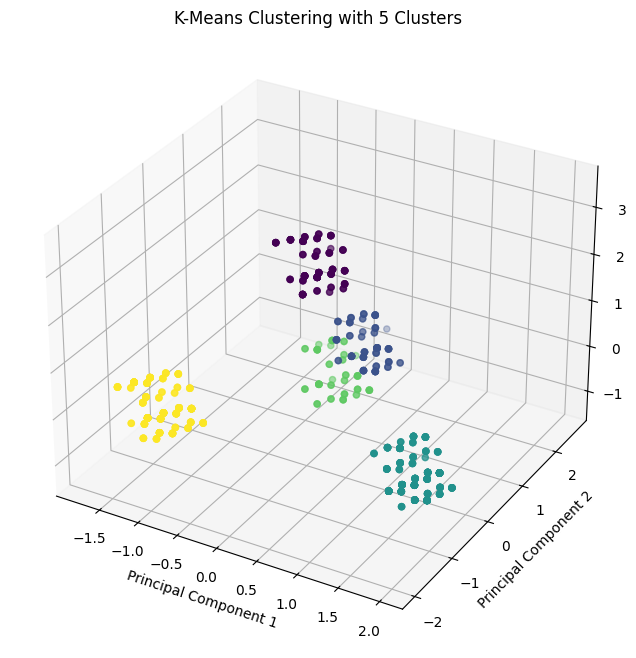

In [159]:
from mpl_toolkits.mplot3d import Axes3D
# Perform K-Means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train_filtered)
labels = kmeans.labels_

# Perform PCA to reduce dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_filtered)

# Plot the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('K-Means Clustering with 5 Clusters')
plt.show()

Now we see 4 distinct clusters. This hints that in fact if we could vizualize well higher dimensions we could see that 5 clusters is best.

Let's see which features were most important.

In [160]:
def calculate_feature_silhouette(X, kmeans_labels):

    feature_silhouette_scores = []

    for column in X.columns:
        # Create a single-feature DataFrame
        feature_data = X[[column]]

        # Standardize the feature
        scaler = StandardScaler()
        feature_scaled = scaler.fit_transform(feature_data)

        # Calculate silhouette score
        try:
            silhouette_avg = silhouette_score(feature_scaled, kmeans_labels)
        except Exception as e:
            silhouette_avg = np.nan

        feature_silhouette_scores.append({
            'Feature': column,
            'Silhouette Score': silhouette_avg
        })

    # Convert to DataFrame and sort by silhouette score
    results_df = pd.DataFrame(feature_silhouette_scores)
    results_df = results_df.sort_values('Silhouette Score', ascending=False)

    return results_df

# Assuming you have already performed K-means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_train_filtered)

# Calculate feature silhouette scores
feature_silhouette_results = calculate_feature_silhouette(X_train_filtered, kmeans.labels_)
print(feature_silhouette_results)

# Optional: Calculate overall dataset silhouette score for comparison
overall_silhouette = silhouette_score(X_train_filtered, kmeans.labels_)
print(f"\nOverall Dataset Silhouette Score: {overall_silhouette}")

                   Feature  Silhouette Score
5             race_group C          0.320331
6             race_group D          0.274232
4             race_group B          0.184397
7             race_group E          0.140662
3             race_group A          0.080378
0            gender_binary         -0.076860
2  test_preparation_binary         -0.097347
8                   edulvl         -0.105773
1             lunch_binary         -0.138266

Overall Dataset Silhouette Score: 0.3779155054245485


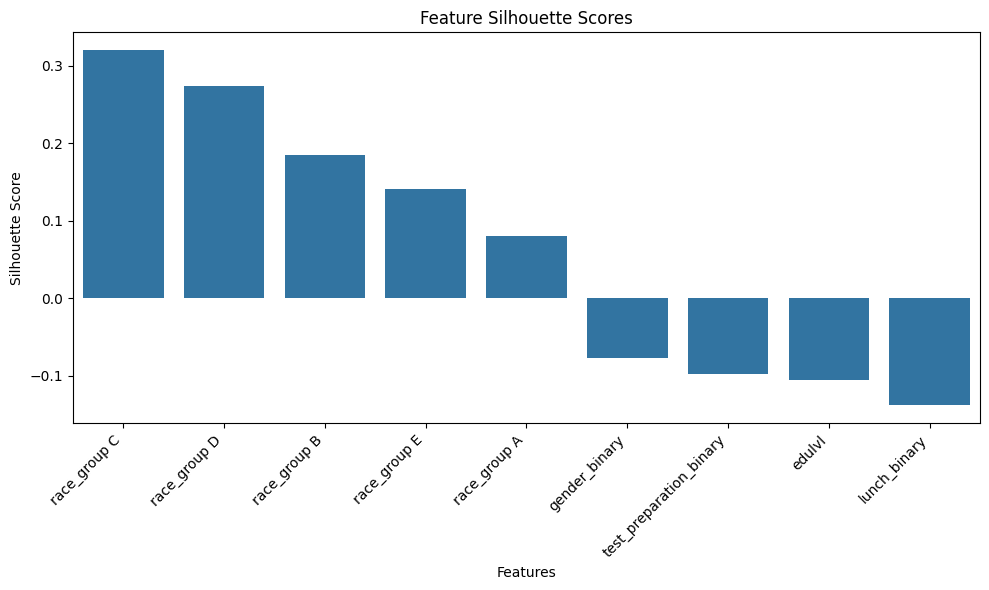

In [161]:
feature_silhouette_results = calculate_feature_silhouette(X_train_filtered, kmeans.labels_)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Silhouette Score', data=feature_silhouette_results)
plt.title('Feature Silhouette Scores')
plt.xlabel('Features')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The clustering is based purely on race, while other features are not uniquely assigned into groups

It seems like the one-hot encoding of races forced the clustering to match races. Next, I will add all the scores variables back to the df and perform PCA before clustering in order to see if other patterns emerge in a DBSCAN clustering

Explained Variance Ratio:
[0.33058938 0.10468077 0.09804447 0.0902845  0.08362884 0.07384916
 0.07084134 0.06597321 0.05365352]

Cumulative Explained Variance:
[0.33058938 0.43527015 0.53331462 0.62359912 0.70722797 0.78107713
 0.85191847 0.91789168 0.97154519]

Number of components selected: 9


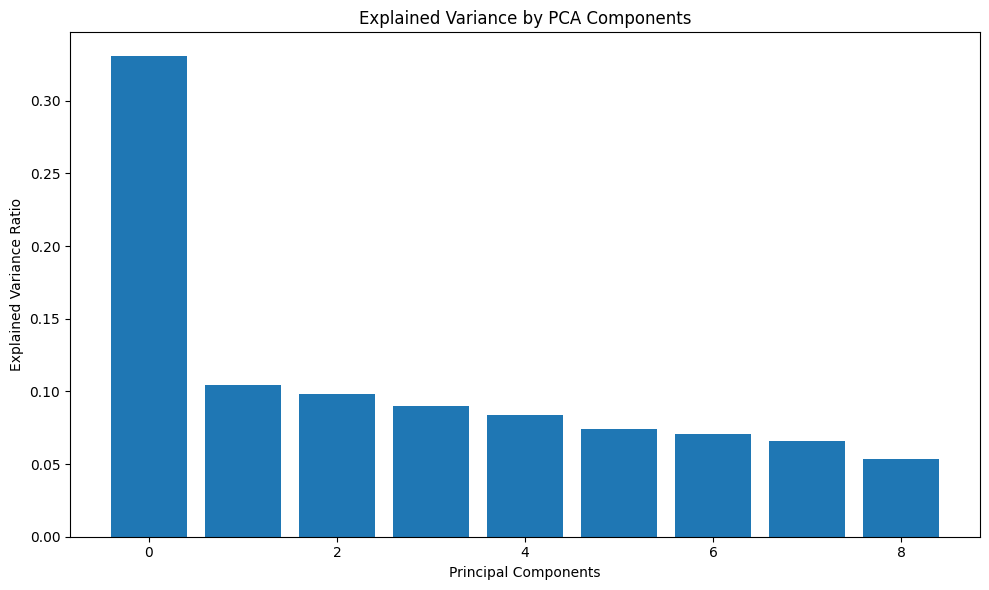

In [162]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_train_combined)

# Print explained variance
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)
print("\nCumulative Explained Variance:")
print(np.cumsum(pca.explained_variance_ratio_))
print(f"\nNumber of components selected: {X_pca.shape[1]}")

# Visualization of PCA Components
plt.figure(figsize=(10, 6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title('Explained Variance by PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.show()

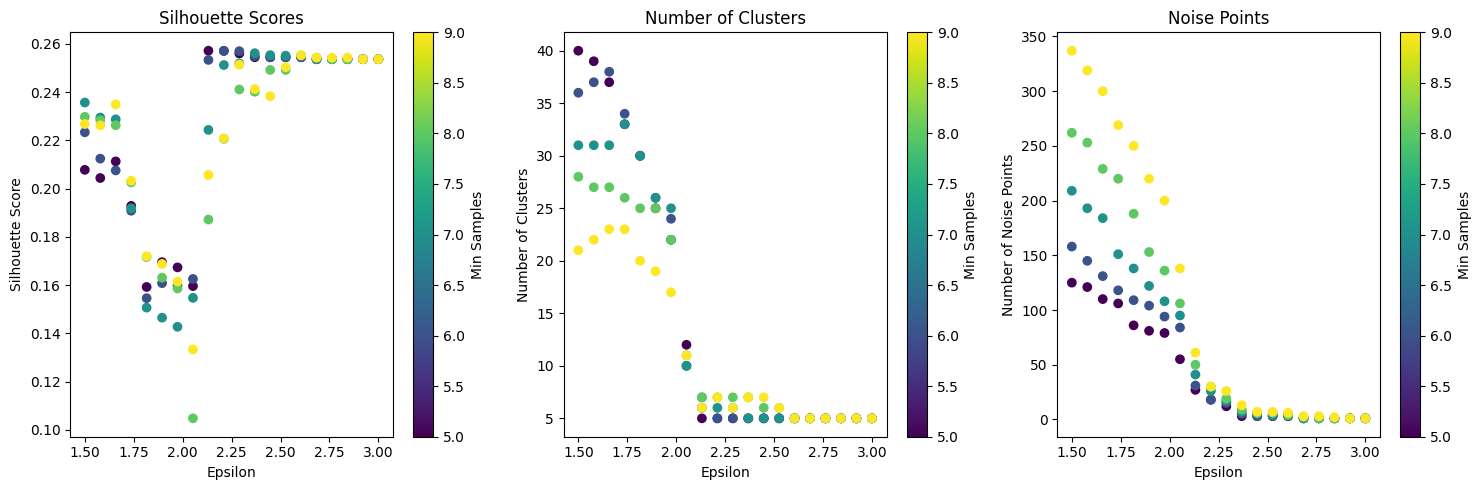


Best DBSCAN Parameters:
Epsilon: 2.1315789473684212
Min Samples: 5
Number of Clusters: 5
Number of Noise Points: 27
Silhouette Score: 0.2571486341042919


In [163]:
# Define parameter ranges more simply
eps_range = np.linspace(1.5, 3, 20)
min_samples_range = range(5, 10)  # For a smaller dataset

def perform_dbscan_parameter_search(X, eps_range, min_samples_range):
    results = []
    best_silhouette = -1
    best_params = None

    for eps in eps_range:
        for min_samples in min_samples_range:
            try:
                # Perform DBSCAN clustering
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(X)

                # Check number of clusters and noise points
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)

                # Calculate silhouette score (excluding noise points)
                if n_clusters > 1:
                    mask = labels != -1
                    silhouette_avg = silhouette_score(X[mask], labels[mask])
                else:
                    silhouette_avg = -1

                result = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette_score': silhouette_avg
                }
                results.append(result)

                # Update best parameters
                if silhouette_avg > best_silhouette:
                    best_silhouette = silhouette_avg
                    best_params = result

            except Exception as e:
                print(f"Error with eps={eps}, min_samples={min_samples}: {e}")

    return results, best_params

# Perform DBSCAN parameter search
dbscan_results, best_dbscan_params = perform_dbscan_parameter_search(
    X_pca, eps_range, min_samples_range
)

# Visualize DBSCAN parameter search results
plt.figure(figsize=(15, 5))

# Silhouette Score
plt.subplot(1, 3, 1)
silhouette_scores = [result['silhouette_score'] for result in dbscan_results if result['silhouette_score'] != -1]
plt.scatter(
    [result['eps'] for result in dbscan_results if result['silhouette_score'] != -1],
    silhouette_scores,
    c=[result['min_samples'] for result in dbscan_results if result['silhouette_score'] != -1],
    cmap='viridis'
)
plt.title('Silhouette Scores')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.colorbar(label='Min Samples')

# Number of Clusters
plt.subplot(1, 3, 2)
plt.scatter(
    [result['eps'] for result in dbscan_results],
    [result['n_clusters'] for result in dbscan_results],
    c=[result['min_samples'] for result in dbscan_results],
    cmap='viridis'
)
plt.title('Number of Clusters')
plt.xlabel('Epsilon')
plt.ylabel('Number of Clusters')
plt.colorbar(label='Min Samples')

# Noise Points
plt.subplot(1, 3, 3)
plt.scatter(
    [result['eps'] for result in dbscan_results],
    [result['n_noise'] for result in dbscan_results],
    c=[result['min_samples'] for result in dbscan_results],
    cmap='viridis'
)
plt.title('Noise Points')
plt.xlabel('Epsilon')
plt.ylabel('Number of Noise Points')
plt.colorbar(label='Min Samples')

plt.tight_layout()
plt.show()

# Print best DBSCAN parameters
print("\nBest DBSCAN Parameters:")
print(f"Epsilon: {best_dbscan_params['eps']}")
print(f"Min Samples: {best_dbscan_params['min_samples']}")
print(f"Number of Clusters: {best_dbscan_params['n_clusters']}")
print(f"Number of Noise Points: {best_dbscan_params['n_noise']}")
print(f"Silhouette Score: {best_dbscan_params['silhouette_score']}")

After much trial and error, we see that DBSCAN can only distinct bw a small amount of clusters (again the best fit is 5) if eps is bigger than 2.

In [164]:
# Perform DBSCAN with best parameters
best_dbscan = DBSCAN(
    eps=best_dbscan_params['eps'],
    min_samples=best_dbscan_params['min_samples']
)
dbscan_labels = best_dbscan.fit_predict(X_pca)

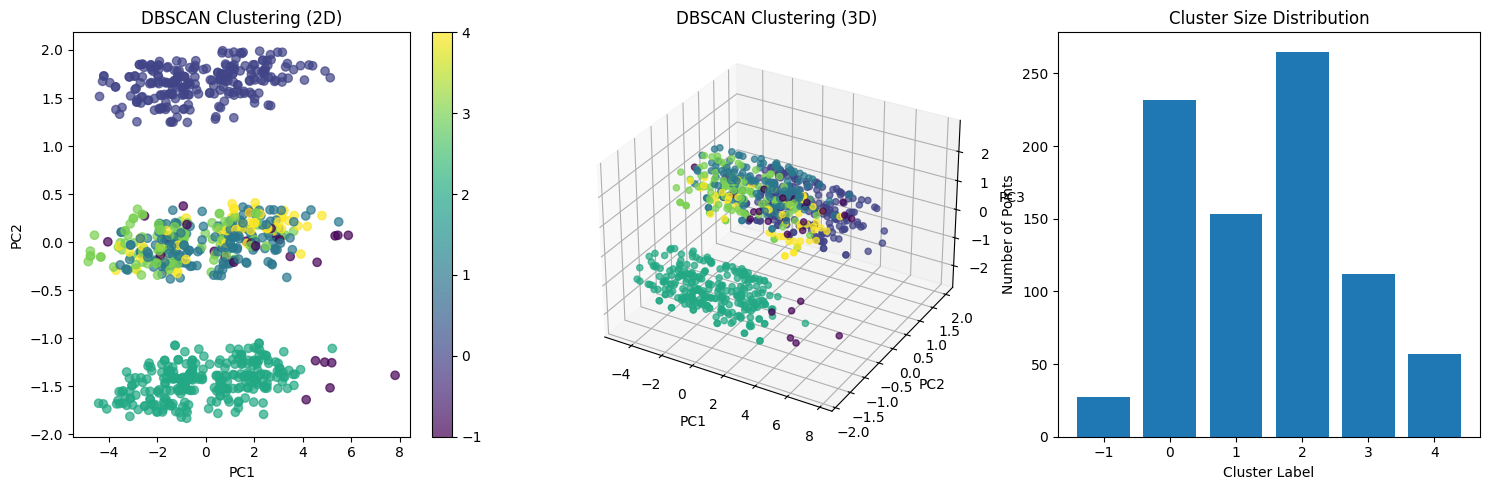

In [165]:
# Create a more informative 3D plot
plt.figure(figsize=(15, 5))

# 2D Plot
plt.subplot(131)
scatter_2d = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter_2d)

# 3D Plot
ax_3d = plt.subplot(132, projection='3d')
scatter_3d = ax_3d.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=dbscan_labels,
    cmap='viridis',
    alpha=0.7
)
ax_3d.set_title('DBSCAN Clustering (3D)')
ax_3d.set_xlabel('PC1')
ax_3d.set_ylabel('PC2')
ax_3d.set_zlabel('PC3')

# Cluster Distribution
plt.subplot(133)
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')

plt.tight_layout()
plt.show()


The distribution of clusters again resembles the race feature.

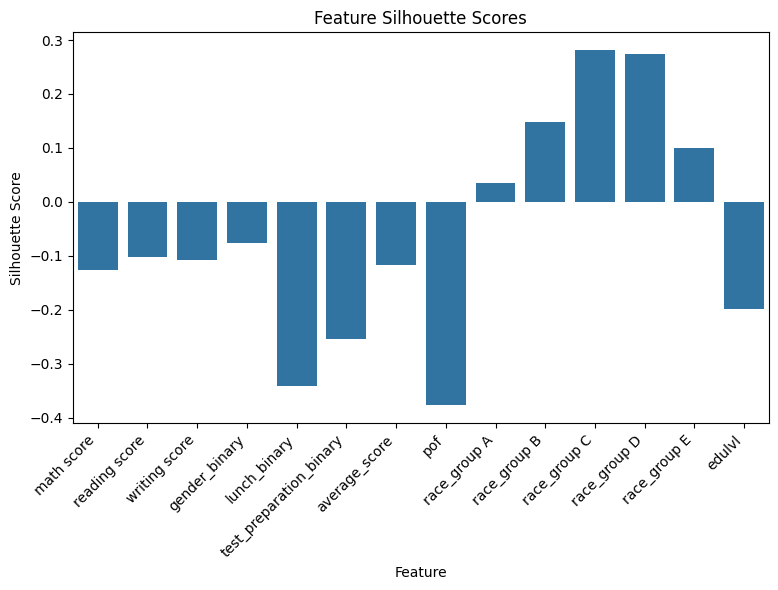


Feature Importance for DBSCAN Clustering:
                    Feature  Silhouette Score
0                math score         -0.125406
1             reading score         -0.102343
2             writing score         -0.107528
3             gender_binary         -0.075563
4              lunch_binary         -0.341265
5   test_preparation_binary         -0.253591
6             average_score         -0.117333
7                       pof         -0.377192
8              race_group A          0.035461
9              race_group B          0.148936
10             race_group C          0.281324
11             race_group D          0.274232
12             race_group E          0.100473
13                   edulvl         -0.198602


In [166]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_feature_importance_dbscan(X, dbscan_labels):

    feature_importance = []

    for column in X.columns:
        try:
            # Silhouette score for individual feature
            from sklearn.preprocessing import StandardScaler
            from sklearn.metrics import silhouette_score

            feature_data = X[[column]]
            scaler = StandardScaler()
            feature_scaled = scaler.fit_transform(feature_data)

            feature_silhouette = silhouette_score(feature_scaled, dbscan_labels)

            feature_importance.append({
                'Feature': column,
                'Silhouette Score': feature_silhouette
            })

        except Exception as e:
            print(f"Error processing {column}: {e}")

    # Convert to DataFrame and sort
    importance_df = pd.DataFrame(feature_importance)
    return importance_df

# Calculate feature importance
feature_importance_results = calculate_feature_importance_dbscan(
    X_train_combined,
    dbscan_labels
)

# Visualization
plt.figure(figsize=(15, 6))

# Silhouette Scores
plt.subplot(122)
sns.barplot(
    x='Feature',
    y='Silhouette Score',
    data=feature_importance_results
)
plt.title('Feature Silhouette Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Print detailed results
print("\nFeature Importance for DBSCAN Clustering:")
print(feature_importance_results)

Same results. Lastly, we will try to completely remove race and check K-Means again.

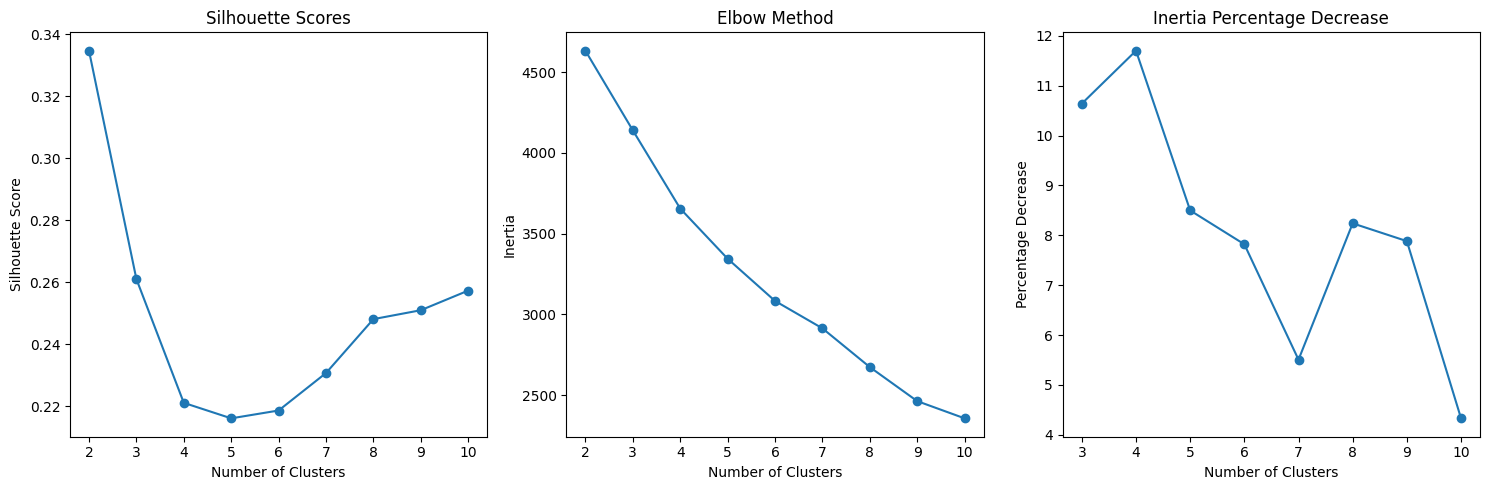

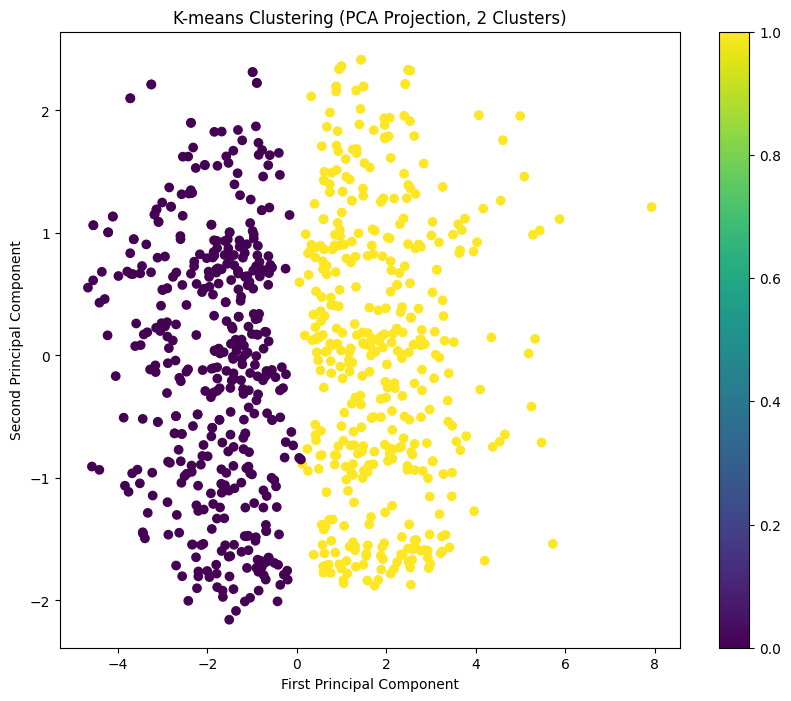


Cluster Composition:
Cluster 0: 431 samples
Cluster 1: 415 samples

Feature Importance:
                   Feature  Cluster Variation
7                      pof           1.000242
6            average_score           0.792806
1            reading score           0.771706
2            writing score           0.758212
0               math score           0.733476
5  test_preparation_binary           0.217574
4             lunch_binary           0.216557
8                   edulvl           0.153929
3            gender_binary           0.072375


In [167]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Remove race features
X_train_no_race = X_train_combined.drop(columns=[
    'race_group A', 'race_group B', 'race_group C',
    'race_group D', 'race_group E'
])

# Perform K-means clustering with different numbers of clusters
def perform_kmeans_clustering(X, max_clusters=10):
    results = []
    inertias = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Calculate silhouette score
        try:
            silhouette_avg = silhouette_score(X, labels)
        except:
            silhouette_avg = -1

        # Store inertia
        inertias.append(kmeans.inertia_)

        results.append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'inertia': kmeans.inertia_
        })

    return results, inertias

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_no_race)

# Find optimal number of clusters
clustering_results, inertias = perform_kmeans_clustering(X_scaled)

# Visualize clustering results
plt.figure(figsize=(15, 5))

# Silhouette Scores
plt.subplot(131)
plt.plot(
    [result['n_clusters'] for result in clustering_results],
    [result['silhouette_score'] for result in clustering_results],
    marker='o'
)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Elbow Method
plt.subplot(132)
plt.plot(range(2, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Percentage Decrease in Inertia
inertia_pct_decrease = [
    (inertias[i-1] - inertias[i]) / inertias[i-1] * 100
    for i in range(1, len(inertias))
]
plt.subplot(133)
plt.plot(range(3, 11), inertia_pct_decrease, marker='o')
plt.title('Inertia Percentage Decrease')
plt.xlabel('Number of Clusters')
plt.ylabel('Percentage Decrease')

plt.tight_layout()
plt.show()

# Optimal clusters based on highest silhouette score
optimal_clusters = max(
    clustering_results,
    key=lambda x: x['silhouette_score']
)['n_clusters']

# Perform K-means clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title(f'K-means Clustering (PCA Projection, {optimal_clusters} Clusters)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Cluster composition analysis
print("\nCluster Composition:")
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} samples")

# Feature importance in clusters
def calculate_cluster_feature_importance(X, labels):
    feature_importance = []

    for column in X.columns:
        # Calculate mean of feature for each cluster
        cluster_means = [
            X.loc[labels == cluster, column].mean()
            for cluster in np.unique(labels)
        ]

        # Calculate variation between cluster means
        feature_variation = np.std(cluster_means)

        feature_importance.append({
            'Feature': column,
            'Cluster Variation': feature_variation
        })

    return pd.DataFrame(feature_importance).sort_values('Cluster Variation', ascending=False)

feature_importance = calculate_cluster_feature_importance(X_train_no_race, cluster_labels)
print("\nFeature Importance:")
print(feature_importance)


plt.show()

We see that the next seperators are the scores (and pof which perfectly distinguishes 50-50). What is standing out though is that lunch, test prep and edulvl are still dispersed.